# Exercise 3: Interatomic potentials

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import sympy as sp
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# a) Interatomic potential shape

<span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Sketch a typical interatomic potential (energy as a function of interatomic distance $r$) and explain your choices. What are the key contributions to this potential? In particular, what is the behavior as $r \to 0$ and $r \to +\infty$?

<div class="alert alert-block alert-light">

## Solution

A typical interatomic potential incorporates two key physical contributions:

1. Short-range repulsion (dominant as $r \to 0$):
   At very small interatomic distances, the potential energy becomes strongly positive due to the overlap of electron clouds, which is prohibited by the Pauli exclusion principle. This repulsive interaction is commonly modeled in different forms across potential functions. For example:

   * In the Lennard-Jones potential the repulsion is represented by a steeply rising $\left(1/r\right)^{12}$ term.
   * In the Morse potential, the repulsion is captured by the exponential term $e^{-2a(r - r_e)}$, where $a$ is a measure of bond stiffness and $r_e$ is the equilibrium bond distance.
   * More sophisticated potentials, such as the Born-Mayer or Buckingham potentials, also use exponential or modified inverse power forms for short-range repulsion.

2. Long-range attraction (dominant as $r \to \infty$):
   At larger distances, the potential is dominated by attractive van der Waals (dispersion) interactions, which arise from correlated fluctuations of instantaneous dipoles. These are typically modeled by terms that decay as $-1/r^6$. For example:

   * The Lennard-Jones potential includes a $-\left(1/r\right)^6$ term to represent dispersion forces.
   * The Morse potential includes an attractive term of the form $-2e^{-a(r - r_e)}$, which smoothly approaches zero as $r \to \infty$.
   * In more complex models like the London dispersion potential, the attraction can also include higher-order multipole contributions depending on the system.

These two competing effects (strong short-range repulsion and weaker long-range attraction) together create a potential well with a minimum at an intermediate equilibrium distance, corresponding to the most stable atomic separation.

---

## The Stillinger-Weber (SW) potential for Si

The **Stillinger–Weber (SW) potential** for silicon was the first practical cluster potential to reproduce the **diamond cubic structure** as the most stable configuration. It captures not only the correct equilibrium bond lengths and angles but also accurately reflects the **energetic cost of distorting** the tetrahedral geometry, making it a foundational model for covalent systems.

Originally designed for **silicon**, the Stillinger–Weber potential uses the form:

#### Two-body term:
$$
v_2(r) = A \varepsilon \left[ B \left( \frac{\sigma}{r} \right)^p - \left( \frac{\sigma}{r} \right)^q \right] \exp\left( \frac{\sigma}{r - a\sigma} \right)
$$

**The exponential function is added to introduce a cutoff radius ($r_{\mathrm{cut}} = a \sigma$) while mantaining the function smooth and continuous.**

#### Three-body term:
$$
v_3(r_{ij}, r_{ik}, \theta) = \lambda \varepsilon \left[ \cos \theta - \cos \theta_0 \right]^2 \exp\left( \frac{\gamma \sigma}{r_{ij} - a\sigma} \right) \exp\left( \frac{\gamma \sigma}{r_{ik} - a\sigma} \right)
$$

- $r_{ij}, r_{ik}$ are pair distances
- $\theta$ is the angle $\angle jik$
- $\cos \theta_0$ defines the preferred bond angle (e.g., tetrahedral for silicon)

The **three-body term** contains an angular component of the form:

$$
\left( \cos \theta_{jik} + \frac{1}{3} \right)^2
$$

This function is minimized when $\cos \theta = -\frac{1}{3}$, corresponding to the **tetrahedral angle** $\theta \approx 109.47^\circ$. As a result, the potential energetically favors tetrahedral coordination and stabilizes the **diamond cubic lattice** found in silicon.

The original parameters determined by Stillinger and Weber are:

| Parameter | Value        | Unit |
|-----------|--------------|------|
| $\sigma$     | 2.0951       | $\mathrm{\AA}$    |
| $\varepsilon$   | 2.1682       | eV   |
| A         | 7.049556277  | —    |
| B         | 0.6022245584 | —    |
| p         | 4            | —    |
| q         | 0            | —    |
| a         | 1.8          | —    |
| $\lambda$ | 21.0          | — |
| $\gamma$ | 1.2          | — |


### Only two-body term:
Assuming ideal bond angles, **we restrict our model to the two-body interaction term**.  

Let's plot it and see what it looks like.

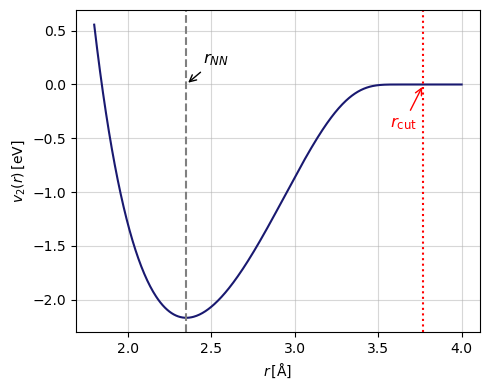

In [2]:
# SW potential parameters
A = 7.049556277
B = 0.6022245584
p = 4
q = 0
a = 1.8 
sigma = 2.0951  # Ångstroms
epsilon = 2.1682  # eV

# Define v2(r)
def v2_real_func(r):
    r_red = r / sigma
    if r >= a * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a))

# Compute data
r_vals_real = np.linspace(1.8, 4.0, 500)
v2_vals = [v2_real_func(r) for r in r_vals_real]

# Important distances
r_NN = 2.35
r_cut = a * sigma

# Plot
plt.figure(figsize=(5, 4))
plt.plot(r_vals_real, v2_vals, color='midnightblue')

# Vertical lines
plt.axvline(x=r_NN, color='gray', linestyle='--')
plt.axvline(x=r_cut, color='red', linestyle=':')

# Annotations
plt.annotate(r'$r_{NN}$', xy=(r_NN, 0), xytext=(r_NN + 0.1, 0.2),
             arrowprops=dict(arrowstyle='->'), fontsize=12)

plt.annotate(fr'$r_{{\mathrm{{cut}}}}$', 
             xy=(r_cut, 0), xytext=(r_cut - 0.2, -0.4),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='red')

# Axes
plt.xlabel(r'$r\,\mathrm{[\AA]}$')
plt.ylabel(r'$v_2(r)\,\mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

---

# b) Parameters and Force
- <span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> What is the relationship between the parameter $\varepsilon$ and the depth of the potential well? Illustrate qualitatively how the shape of the potential changes as 
$\varepsilon$ varies.  
  -  Hint: You can change `epsilon` in the previous code snippet and see how the plot changes.

- <span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Given the shape of the two-body term in the Stillinger-Weber potential, sketch the corresponding force $F(r)$ as a function of distance $r$. What is the relationship between force and potential?

- <span style="color:blue; font-variant:small-caps;">(PYTHON)</span> By setting the interatomic force to zero, we determine the distance $r_{ij}$ at which the potential reaches its minimum. This distance corresponds to the equilibrium bond length between first neighbors. Run the code and compare your result to the experimental value of $2.35\,\text{\AA}$.

- <span style="color:blue; font-variant:small-caps;">(PYTHON)</span> Next, evaluate `v2_real_func` at `r_min` to obtain the energy at the minimum: do you recognize the value?.

- <span style="color:violet; font-variant:small-caps;">(OPTIONAL)</span> Use the function that calculates the force to plot $F(r)$


In [3]:
# Define numerical derivative: force = -dv2/dr
def force_real_func(r, h=1e-6):
    return -(v2_real_func(r + h) - v2_real_func(r - h)) / (2 * h)

# Use minimize_scalar on |force| to find the root of the force
force_root_result = minimize_scalar(lambda r: abs(force_real_func(r)),
                                    bounds=(2.0, a * sigma - 1e-4),
                                    method='bounded')

r_NN = force_root_result.x if force_root_result.success else None

print(f'rNN = {r_NN:.4f} Å')

E_min = v2_real_func(r_NN)
print(f'v2(rNN) = {E_min:.4f} eV')

rNN = 2.3517 Å
v2(rNN) = -2.1682 eV


<div class="alert alert-block alert-light">

## Solution

### Force calculation
We compute the gradient of the potential to find the force between atoms $i$ and $j$:

$$
\begin{align*}
- \nabla_{\mathbf{r}_i} v_2(r_{ij}) 
&= - \frac{\partial}{\partial \mathbf{r}_i} \left\{ \varepsilon A \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \exp \left[ \left( r_{ij} - a \right)^{-1} \right] \right\} \\
&= - \varepsilon A \frac{\mathbf{r}_{ij}}{r_{ij}} \left( \left[ \frac{\partial}{\partial r} \left( B r^{-p} - r^{-q} \right) \right] \bigg|_{r_{ij}} \exp \left[ \left( r_{ij} - a \right)^{-1} \right] \right. \\
&\quad + \left. \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \left\{ \frac{\partial}{\partial r} \exp \left[ (r - a)^{-1} \right] \right\} \bigg|_{r_{ij}} \right) \\
&= - \varepsilon A \frac{\mathbf{r}_{ij}}{r_{ij}} \left\{ \left( -p B r_{ij}^{-p-1} + q r_{ij}^{-q-1} \right) \exp \left[ (r_{ij} - a)^{-1} \right] \right. \\
&\quad - \left. \left( B r_{ij}^{-p} - r_{ij}^{-q} \right) \exp \left[ (r_{ij} - a)^{-1} \right] (r_{ij} - a)^{-2} \right\} \\
&= v_2 \frac{\mathbf{r}_{ij}}{r_{ij}} \left[ \frac{p B r_{ij}^{-p-1} - q r_{ij}^{-q-1}}{B r_{ij}^{-p} - r_{ij}^{-q}} + (r_{ij} - a)^{-2} \right] \\
&\equiv \mathbf{f}_{ij}
\end{align*}
$$

By solving ${f}_{ij} = 0$, we find:

$r_{\text{NN}} = 2.3517\,\text{\AA}$.

This agrees well with the experimental value of $2.35\,\text{\AA}$, as expected, since the potential was specifically fitted to reproduce such properties.

The depth of the potential well is $−2.1682\,\text{eV} = \varepsilon$.

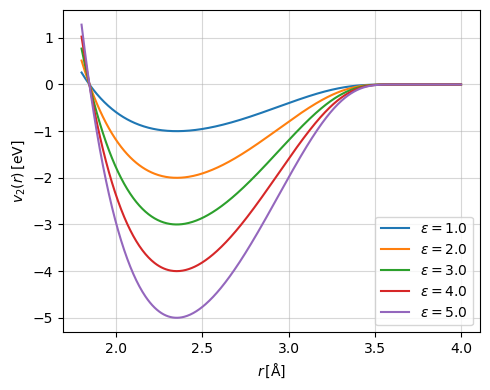

In [4]:
# Compute data
r_vals_real = np.linspace(1.8, 4.0, 500)

# Plot
plt.figure(figsize=(5, 4))
for epsilon in np.arange(1, 6, 1.0):
    v2_vals = [v2_real_func(r) for r in r_vals_real]
    plt.plot(r_vals_real, v2_vals, label=f'$\epsilon={epsilon}$')

# Axes
plt.xlabel(r'$r\,\mathrm{[\AA]}$')
plt.ylabel(r'$v_2(r)\,\mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

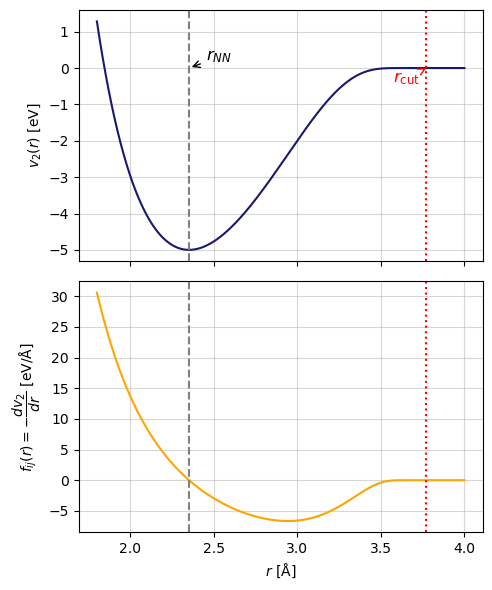

In [5]:
## ----------- SOLUTION -------------------------------


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))

r_vals_real = np.linspace(1.8, 4, 500)
v2_vals = [v2_real_func(r) for r in r_vals_real]
force_vals = [force_real_func(r) for r in r_vals_real]


ax1.plot(r_vals_real, v2_vals, color='midnightblue')
ax1.axvline(x=2.35, color='gray', linestyle='--')
ax1.axvline(x=a * sigma, color='red', linestyle=':')
# Annotations
ax1.annotate(r'$r_{NN}$', xy=(r_NN, 0), xytext=(r_NN + 0.1, 0.2),
             arrowprops=dict(arrowstyle='->'), fontsize=12)

ax1.annotate(fr'$r_{{\mathrm{{cut}}}}$', 
             xy=(r_cut, 0), xytext=(r_cut - 0.2, -0.4),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='red')
ax1.set_ylabel(r'$v_2(r)\ \mathrm{[eV]}$')

ax1.grid(alpha=0.5)


# Plot force with LaTeX labels
ax2.plot(r_vals_real, force_vals, color='orange')
ax2.axvline(x=2.35, color='gray', linestyle='--')
ax2.axvline(x=a * sigma, color='red', linestyle=':')
ax2.set_xlabel(r'$r\ \mathrm{[\AA]}$')
ax2.set_ylabel(r'$f_{ij}(r) = -\dfrac{dv_2}{dr}\ \mathrm{[eV/\AA]}$')
ax2.grid(alpha=0.5)

plt.tight_layout()
plt.show()

---

# c) Lattice constant 

<span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Use the nearest-neighbor distance to calculate the lattice constant, taking into account the crystal structure of silicon.

<div class="alert alert-block alert-light">

## Solution

Silicon crystallizes in a **diamond cubic** structure, which is a face-centered cubic (FCC) lattice with a 2-atom basis.

* In this structure, the **nearest-neighbor atoms** are along the body diagonals.
* The **NN distance** corresponds to:

  $$
  r_{\text{NN}} = \frac{\sqrt{3}}{4} a_0
  $$

  where $a$ is the **lattice constant**.


Solve for $a_0$:

$$
a_0 = \frac{4}{\sqrt{3}} \approx 5.431\ \mathrm{\AA}
$$

---

## d) Counting interactions

<span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Based on your calculations and the given parameters, determine the number of neighboring atomic shells included within the Stillinger–Weber potential cutoff radius.

<div class="alert alert-block alert-light">

## Solution

In the diamond cubic structure, each atom has:

* 4 first-nearest neighbors
* 12 second-nearest neighbors
* 12 third-nearest neighbors
* and so on...

The 12 second neighbors are at a distance of:

  $$
  r_{\text{2nd}} = \frac{a}{\sqrt{2}} \approx \frac{5.43}{1.414} \approx 3.84\ \text{Å}
  $$

But the cutoff of the SW potential is $r_{\text{cut}} = 1.8\,\sigma = 3.7712\ \text{Å}$, therefore:

* 1st NN: 4 neighbors at $r_1 = 2.3517$ Å $\implies$ included

* 2nd NN: 12 neighbors at $r_2 = \frac{a}{\sqrt{2}} \approx 3.84$ Å $\implies$ outside cutoff

---

# e) Compute energy per atom

- <span style="color:green; font-variant:small-caps;">(PEN & PAPER)</span> Compute the energy per atom by considering only first-neighbor interactions and neglecting any angular (directional bonding) contributions.

- <span style="color:blue; font-variant:small-caps;">(PYTHON)</span> From this, we can compute the equation of state $E(V)$, which describes how the total energy per atom varies with the atomic volume. In practice, this involves sweeping over different values of the lattice parameter, since the volume of the unit cell (and hence the volume per atom) depends directly on the lattice parameter. For each value of the lattice parameter $a_0$, we calculate the corresponding energy per atom considering that for the diamond cubic structure, the unit cell is cubic and contains 8 atoms.

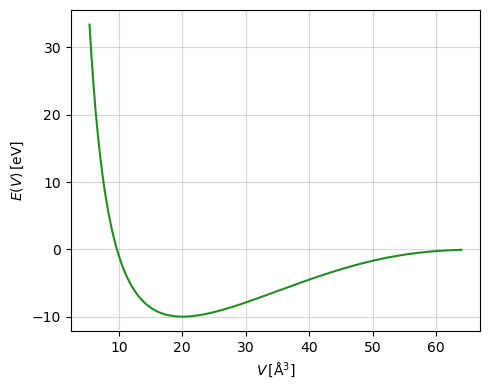

In [6]:
def energy_per_atom_NN(a0):
    r_NN = (np.sqrt(3) / 4) * a0
    v = v2_real_func(r_NN)
    z = 4                               
    return 0.5 * z * v                  

a0_vals = np.linspace(3.5, 8.0, 200)  
volumes = (a0_vals ** 3) / 8          
energies_NN = [energy_per_atom_NN(a0) for a0 in a0_vals]

# Plot E(V)
plt.figure(figsize=(5, 4))
plt.plot(volumes, energies_NN, color='forestgreen')
plt.xlabel(r'$V\,\mathrm{[\AA^3]}$')
plt.ylabel(r'$E(V)\,\mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-light">

## Solution

We'll compute the energy per atom by summing up the pairwise potential contributions from all neighbors, using the fact that:

$$
E_{\text{atom}} = \frac{1}{2} \sum_j v_2(r_{ij})
$$

The factor of ½ avoids double-counting since each interaction is shared between two atoms.

$$
E_{\text{atom}} = \frac{1}{2} \sum_{j=1}^{4} v_2(r_{ij}) = 2 \cdot v_2(r_{\text{NN}}) = 2 \varepsilon
$$

The two-body energy per atom in the diamond structure of silicon, using the Stillinger–Weber potential and including only first-neighbor interactions, is then:

$$
\boxed{E_{\text{atom}}^{(2)} \approx -4.34\ \mathrm{eV}}
$$


This is reasonably close to the known cohesive energy of silicon ($\approx 4.63\,\mathrm{eV/atom}$), but somehow not exact.

---

## f) Include second neighbors in the cutoff

<span style="color:blue; font-variant:small-caps;">(PYTHON)</span> Define a new cutoff value `a_modified` in the range $1.80 <$ `a_modified` $< 2.14$ to ensure that second-nearest neighbor interactions are included.


- Plot both the pair potential and the equation of state with the new cutoff.

- Compare them to the original curves. How do the shapes of the curves depend on the cutoff? 

- What changes? Why? Briefly explain. 

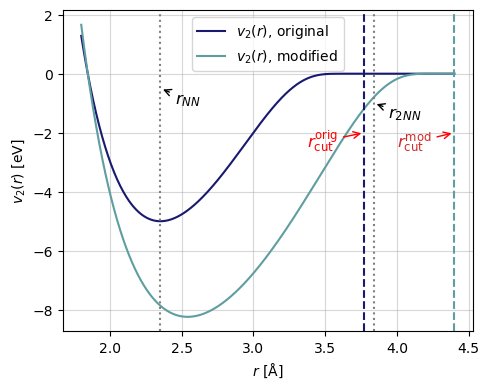

In [7]:
# Cutoff values
a_original = 1.8
a_modified = 2.1 # new cutoff value

# Define v2 as a function of cutoff
def v2(r, a_cut):
    r_red = r / sigma
    if r >= a_cut * sigma:
        return 0.0
    return epsilon * A * (B * r_red**(-p) - r_red**(-q)) * np.exp(1 / (r_red - a_cut))

# Distance values
r_vals = np.linspace(1.8, a_modified * sigma - 1e-4, 500)
v2_vals_orig = [v2(r, a_original) for r in r_vals]
v2_vals_mod = [v2(r, a_modified) for r in r_vals]

# Important distances
r_NN = 2.3517
r_2NN = 3.84
r_cut_orig = a_original * sigma
r_cut_mod = a_modified * sigma

# Plot
plt.figure(figsize=(5, 4))
plt.plot(r_vals, v2_vals_orig, color='midnightblue', label=r'$v_2(r)$, original')
plt.plot(r_vals, v2_vals_mod, color='cadetblue', lw=1.5, label=r'$v_2(r)$, modified')

# Vertical lines
plt.axvline(x=r_NN, color='gray', linestyle=':')
plt.axvline(x=r_2NN, color='gray', linestyle=':')
plt.axvline(x=r_cut_orig, color='midnightblue', linestyle='--')
plt.axvline(x=r_cut_mod, color='cadetblue', linestyle='--')

# Annotations
plt.annotate(r'$r_{NN}$', xy=(r_NN, -0.5), xytext=(r_NN + 0.1, -1),
             arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.annotate(r'$r_{2NN}$', xy=(r_2NN, -1), xytext=(r_2NN + 0.1, -1.5),
             arrowprops=dict(arrowstyle='->'), fontsize=12)
plt.annotate(fr'$r^{{\mathrm{{orig}}}}_{{\mathrm{{cut}}}}$', 
             xy=(r_cut_orig, -2), xytext=(r_cut_orig - 0.4, -2.5),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='red')
plt.annotate(fr'$r^{{\mathrm{{mod}}}}_{{\mathrm{{cut}}}}$', 
             xy=(r_cut_mod, -2), xytext=(r_cut_mod - 0.4, -2.5),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=12, color='tab:red')

# Axes
plt.xlabel(r'$r\ \mathrm{[\AA]}$')
plt.ylabel(r'$v_2(r)\ \mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

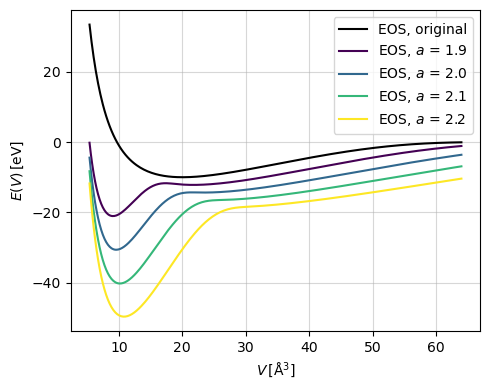

In [8]:
# Energy per atom including 2nd nearest neighbors
def energy_per_atom_2NN(a0, a_cutoff):
    r_NN = (np.sqrt(3) / 4) * a0
    r_2NN = a0 / np.sqrt(2)

    v_NN = v2(r_NN, a_cutoff)
    v_2NN = v2(r_2NN, a_cutoff)

    z1 = 4   # number of 1st neighbors in diamond cubic
    z2 = 12  # number of 2nd neighbors

    return 0.5 * (z1 * v_NN + z2 * v_2NN)

# Volume per atom in diamond cubic
def volume_per_atom(a0):
    return a0**3 / 8

# Lattice parameter sweep
a0_vals = np.linspace(3.5, 8.0, 200)
volumes = [volume_per_atom(a0) for a0 in a0_vals]

# Cutoff values to explore
cutoff_vals = np.arange(1.9, 2.2, 0.1)
energy_curves = {}

# Normalize colormap over range of cutoff values
norm = Normalize(vmin=cutoff_vals.min(), vmax=cutoff_vals.max())

# Compute energy curves
for a_cutoff in cutoff_vals:
    energies = [energy_per_atom_2NN(a0, a_cutoff) for a0 in a0_vals]
    energy_curves[a_cutoff] = energies

# Plot E(V)
plt.figure(figsize=(5, 4))

# Original (first-neighbor) curve
plt.plot(volumes, energies_NN, color='black', label='EOS, original')

# 2NN curves with Viridis colormap
for a_cutoff in cutoff_vals:
    color = viridis(norm(a_cutoff))
    plt.plot(volumes, energy_curves[a_cutoff], label=f'EOS, $a$ = {a_cutoff:.1f}', color=color)

plt.xlabel(r'$V\,\mathrm{[\AA^3]}$')
plt.ylabel(r'$E(V)\,\mathrm{[eV]}$')
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-light">

## Solution

The Stillinger–Weber pair potential includes a distance-based cutoff via an exponential function:

$$
v_2(r) = 
\begin{cases}
A \varepsilon \left[ B \left( \dfrac{\sigma}{r} \right)^p - \left( \dfrac{\sigma}{r} \right)^q \right] \exp\left( \dfrac{\sigma}{r - a\sigma} \right), & \text{for } r < a\sigma \\
0, & \text{for } r \geq a\sigma
\end{cases}
$$



### Include second neighbors in the pair potential 

As the cutoff parameter $a$ increases, the exponential term in the potential decays more slowly. This effectively extends the interaction range, allowing attractive contributions from second-nearest neighbors to influence the potential. The presence of these additional interactions introduces a competition between first-nearest and second-nearest neighbor bonds. As a result, the position of the potential minimum shifts to larger interatomic distances ($r_{\text{min}} > r_{\text{NN}}$). Furthermore, the inclusion of more bonding interactions leads to a greater overall energy gain, causing the minimum to shift downward.

These changes are not captured by the original parameterization of the Stillinger-Weber potential, which is inherently limited to first-neighbor interactions. As a result, the extended interaction range introduces systematic errors, including overbinding and an overestimation of the equilibrium bond length.

### Equation of State (EOS) with second neighbors included 

Since we are now including second-neighbor interactions, we can simplify the summation in the total energy per atom as:

$$
E_{\text{atom}} = \frac{1}{2} \sum_j v_2(r_{ij}) = \frac{1}{2} \sum_{j=1}^{4} v_2(r_{ij}) = \frac{1}{2} \left[ Z_{\text{NN}}\, v_2(r_{\text{NN}}) + Z_{2\text{NN}}\, v_2(r_{2\text{NN}}) \right]
$$

where:

$$
r_{\text{NN}} = \frac{\sqrt{3}}{4} a_0, \quad
r_{2\text{NN}} = \frac{a_0}{\sqrt{2}}, \quad
\frac{V}{\text{atom}} = \frac{a_0^3}{8}
$$

To obtain the equation of state (EOS), we compute the total energy for various atomic volumes using the relations defined above. Compared to the original EOS with a lower cutoff (which excludes second neighbors), the new curve may exhibit two apparent minima.

Increasing the cutoff radius in the pair potential causes the interaction $v_2(r)$ to become nonzero at the second-neighbor distance $r_{2\text{NN}}$, thereby including second-neighbor contributions in the energy calculation. 

Due to their higher coordination number (12), second neighbors can contribute significantly to the total energy, especially as the volume decreases and their separation approaches the potential minimum. This contribution continues to grow until repulsion from first neighbors becomes dominant at smaller volumes.
Their cumulative effect can alter the curvature of the energy–volume curve and introduce artifacts such as a second minimum if their influence becomes dominant.

> A model is only valid within the scope of the assumptions on which it was constructed. If those assumptions are altered, the model may still produce numerical results, but these outputs may no longer correspond to physically meaningful behavior.